#### Hamza BOUKRAICHI and Loïc CORDONE

# Recurrent Neural Networks

Lorsque l'on utilise des réseaux de neurones classiques, les entrées et les sorties sont indépendantes les unes des autres. Cette indépendance est problématique lorsque les données traitées par le réseau sont temporelles, par exemple : une phrase, un enregistrement audio, une vidéo, ou simplement une fonction mathématique. Un réseau traditionnel ne peut pas capable de traduire le 6ème mot d'une phrase sans connaître les 5 mots précédents, voire même la traduction des 5 mots précédents.

Les réseaux de neurones récurrents résolvent ce problème en ajoutant une boucle au réseau entier : les entrées précédentes du réseau sont encodées sous la forme d'un état caché (hidden state) et devient une entrée aux cotés de l'entrée suivante. Le réseau peut alors utiliser les entrées et les états cachés précédents pour mieux traiter la donnée actuelle.

<img src="files/files/rnn_loop.png">

En pratique, le calcul des états cachés se fait à l'intérieur de ce qu'on appelle une "cellule RNN" :

<img src="files/files/rnn_cell.gif">

# Vanishing Gradient et Short-Time memory
Les états cachés fonctionnent donc comme une mémoire pour le réseau, chaque état caché représentant la synthèse des états cachés et des entrées précédentes. Au fur et à mesure qu'il traite les données, le réseau a de plus en plus de mal à retenir l'information éloignée de l'étape courante, on dit qu'il a une mémoire à court-terme. Cela provient de la méthode d'entraînement du RNN, appelée Back-Propagation Through Time, qui permet de considérer chaque étape comme une couche. Le Vanishing Gradient, un problème présent dans les réseaux de neurones classiques, se manifeste et provoque la mémoire à court-terme.

<img src="files/files/rnn_beau.gif">

# LSTM
These operations are used to allow the LSTM to keep or forget information. Now looking at these operations can get a little overwhelming so we’ll go over this step by step.
Core Concept

The core concept of LSTM’s are the cell state, and it’s various gates. The cell state act as a transport highway that transfers relative information all the way down the sequence chain. You can think of it as the “memory” of the network. The cell state, in theory, can carry relevant information throughout the processing of the sequence. So even information from the earlier time steps can make it’s way to later time steps, reducing the effects of short-term memory. As the cell state goes on its journey, information get’s added or removed to the cell state via gates. The gates are different neural networks that decide which information is allowed on the cell state. The gates can learn what information is relevant to keep or forget during training.

<img src="files/files/lstm.png">

## LSTM : Forget Gate
First, we have the forget gate. This gate decides what information should be thrown away or kept. Information from the previous hidden state and information from the current input is passed through the sigmoid function. Values come out between 0 and 1. The closer to 0 means to forget, and the closer to 1 means to keep.

<img src="files/files/lstm_forget.gif">

## LSTM : Input Gate
To update the cell state, we have the input gate. First, we pass the previous hidden state and current input into a sigmoid function. That decides which values will be updated by transforming the values to be between 0 and 1. 0 means not important, and 1 means important. You also pass the hidden state and current input into the tanh function to squish values between -1 and 1 to help regulate the network. Then you multiply the tanh output with the sigmoid output. The sigmoid output will decide which information is important to keep from the tanh output.

<img src="files/files/lstm_input.gif">

## LSTM : Cell State
Now we should have enough information to calculate the cell state. First, the cell state gets pointwise multiplied by the forget vector. This has a possibility of dropping values in the cell state if it gets multiplied by values near 0. Then we take the output from the input gate and do a pointwise addition which updates the cell state to new values that the neural network finds relevant. That gives us our new cell state.

<img src="files/files/lstm_cell.gif">

## LSTM : Output Gate
Last we have the output gate. The output gate decides what the next hidden state should be. Remember that the hidden state contains information on previous inputs. The hidden state is also used for predictions. First, we pass the previous hidden state and the current input into a sigmoid function. Then we pass the newly modified cell state to the tanh function. We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. The output is the hidden state. The new cell state and the new hidden is then carried over to the next time step.

<img src="files/files/lstm_output.gif">

To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

# GRU
So now we know how an LSTM work, let’s briefly look at the GRU. The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate.

<img src="files/files/gru.png">

## GRU : Update Gate

The update gate acts similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add.

## GRU : Reset Gate

The reset gate is another gate is used to decide how much past information to forget.

And that’s a GRU. GRU’s has fewer tensor operations; therefore, they are a little speedier to train then LSTM’s. There isn’t a clear winner which one is better. Researchers and engineers usually try both to determine which one works better for their use case.

# LSTM vs GRU

<img src="files/files/gru_lstm.png">

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib

import matplotlib.pyplot as plt

SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

T = 20
L = 1000
N = 100

# Generate Training Data

In [2]:
x = np.empty((N, L), 'int32')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float32')

# load data and make training set
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
print (input.shape)
print (target.shape)

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
print (test_input.shape)
print (test_target.shape)

torch.Size([97, 999])
torch.Size([97, 999])
torch.Size([3, 999])
torch.Size([3, 999])


# Model

In [3]:
class Sequence(nn.Module):
    def __init__(self, hdim):
        super(Sequence, self).__init__()
        self.rnn = nn.GRUCell(1, hdim)
        self.linear = nn.Linear(hdim, 1)
        self.hdim = hdim

    def forward(self, input, future = 0):
        outputs = []
        
        # create a tensor for the hidden state initialized to zero
        h_t = torch.zeros((input.size(0),self.hdim))

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            # apply the RNN
            h_t = self.rnn(input_t,h_t)
            # apply the linear layer 
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):# if we should predict the future
            
            # apply the RNN to the last value
            h_t =  self.rnn(output,h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [4]:
# build the model with 5 hidden units
seq = Sequence(5)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# TRAIN AND TEST

STEP: 0 loss: 0.0006040062871761623 test loss: 0.0005961318966001272


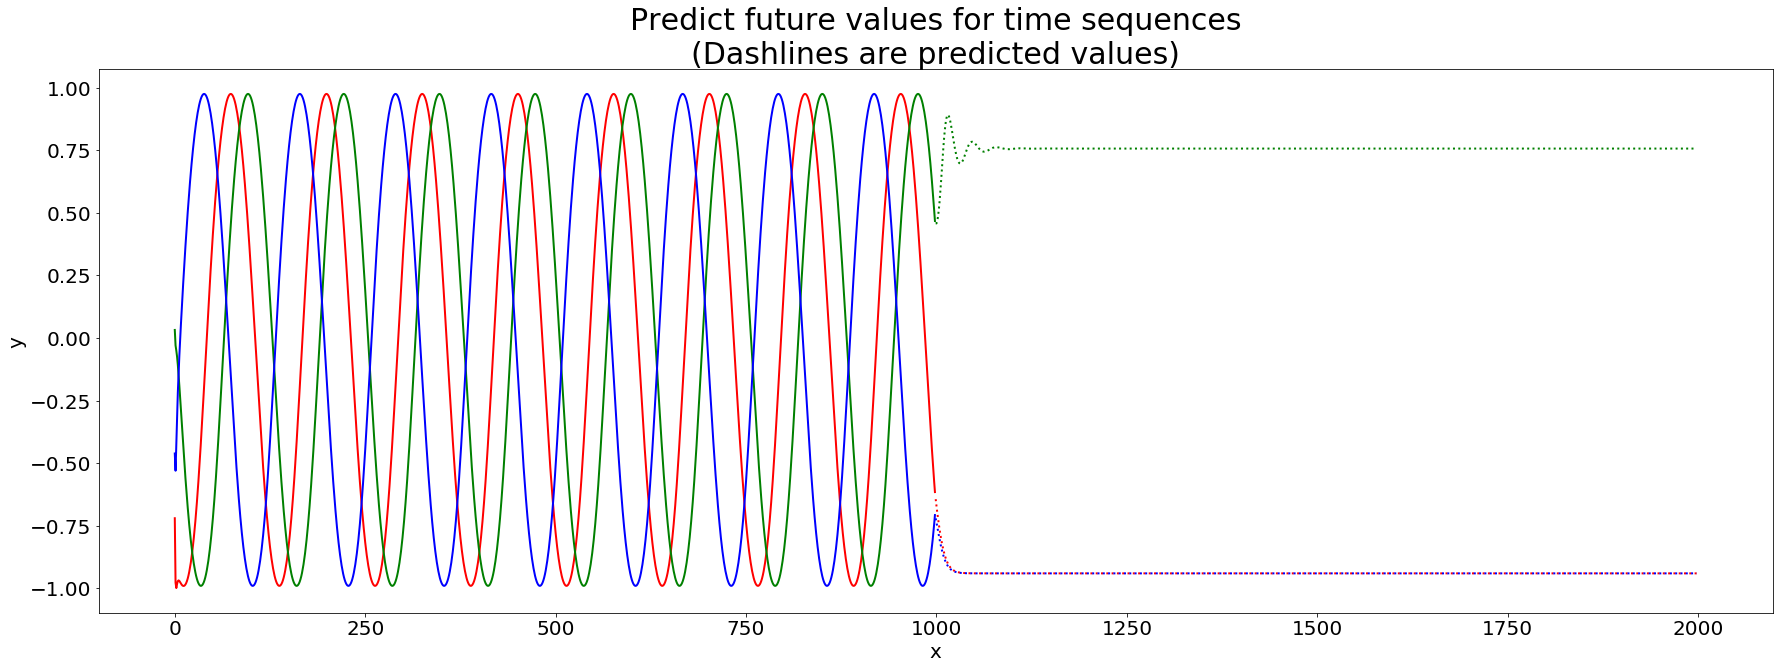

STEP: 1 loss: 0.00010061210195999593 test loss: 0.00011732916755136102


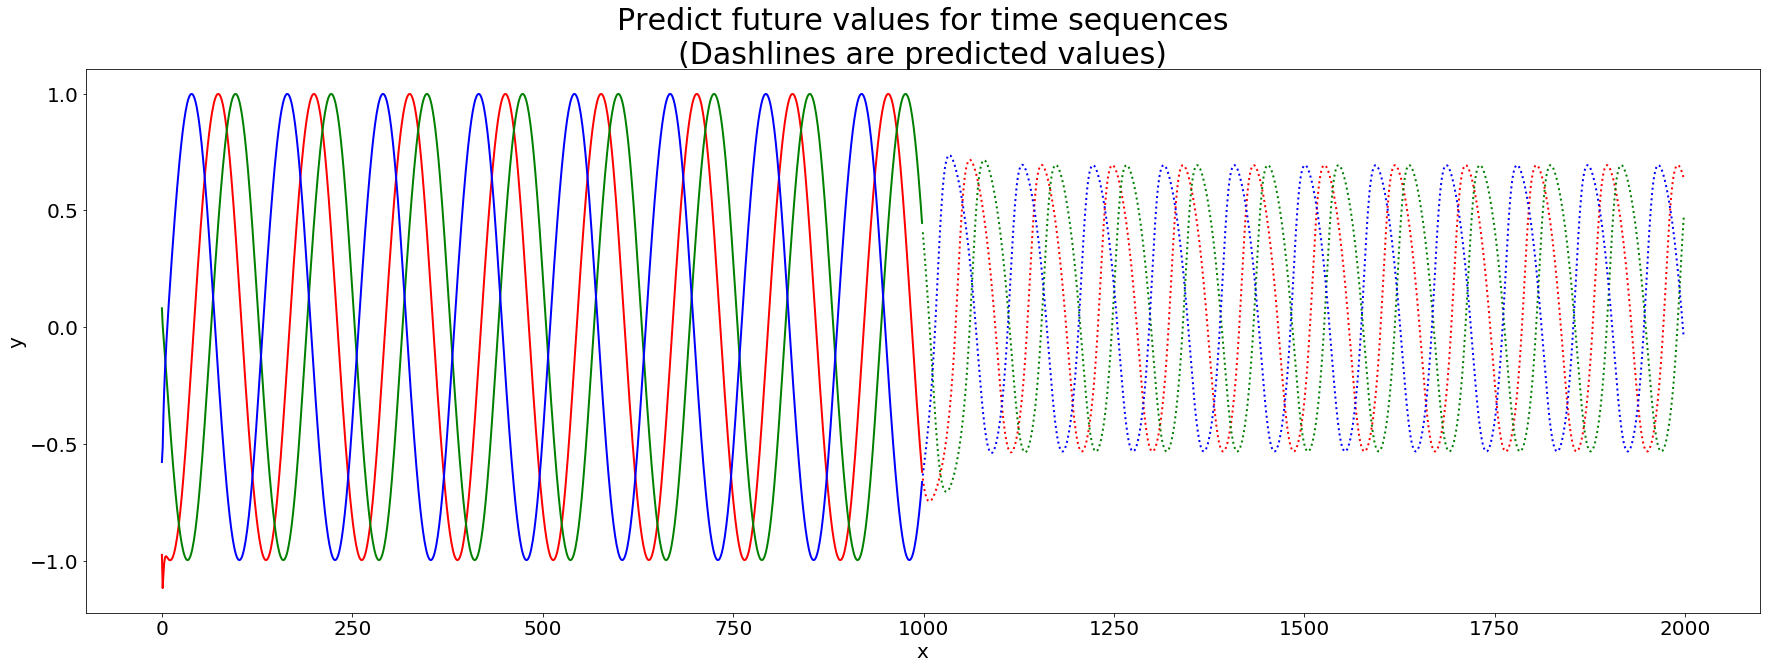

STEP: 2 loss: 5.892345870961435e-055 test loss: 5.1829134463332593e-05


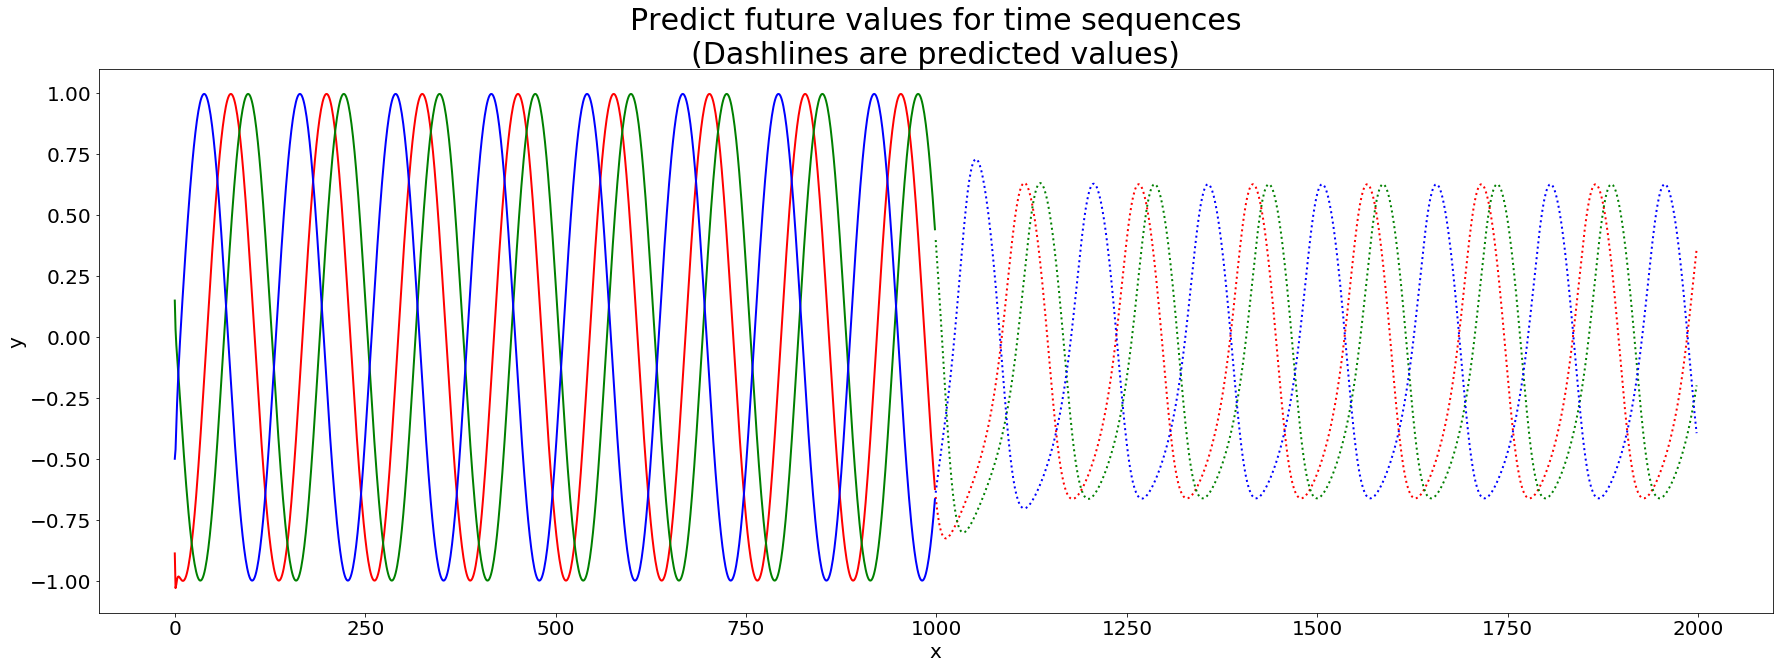

STEP: 3 loss: 3.8043704989831895e-05 test loss: 4.244441879563965e-05


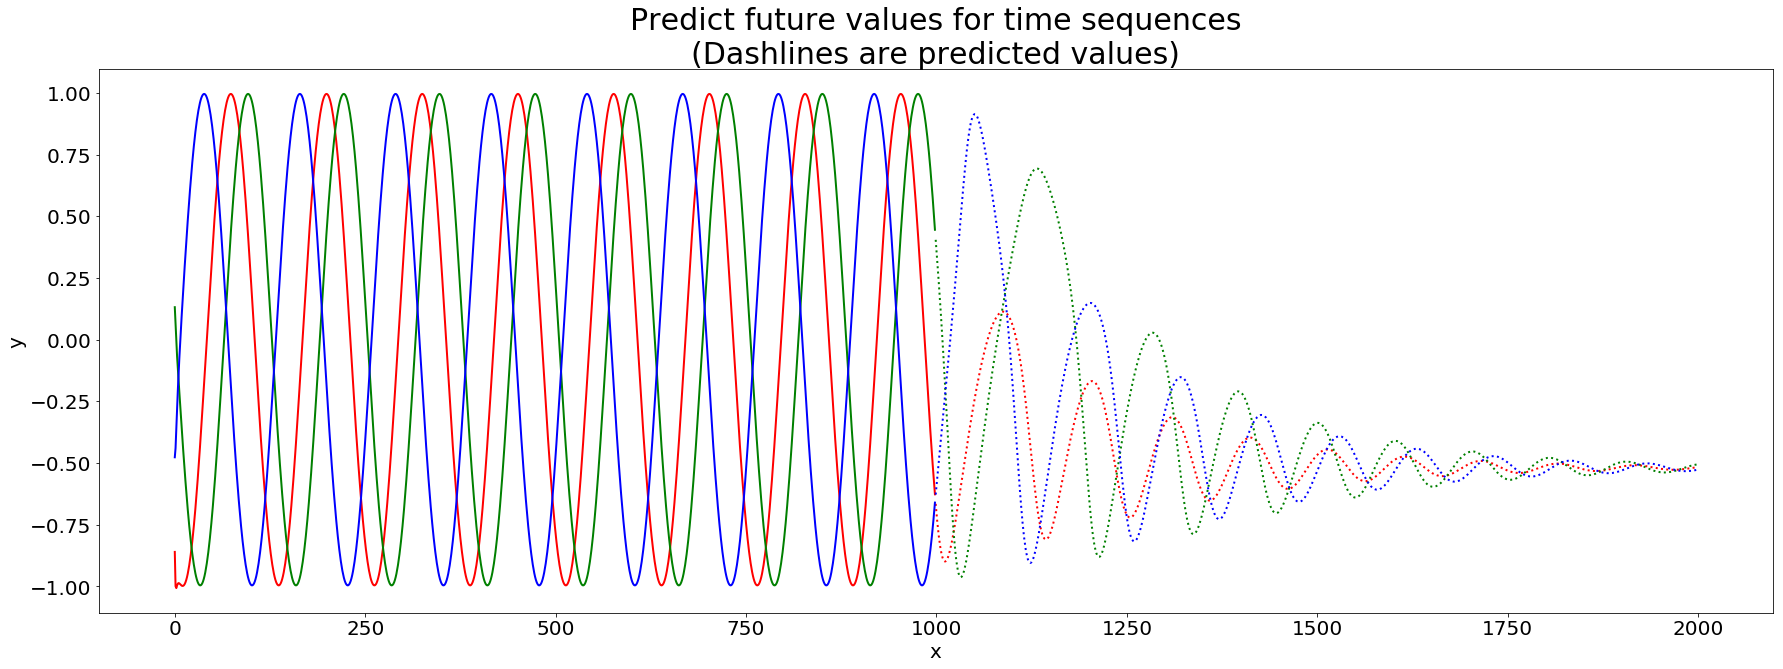

STEP: 4 loss: 2.3234586478793062e-05 test loss: 2.186973324569408e-05


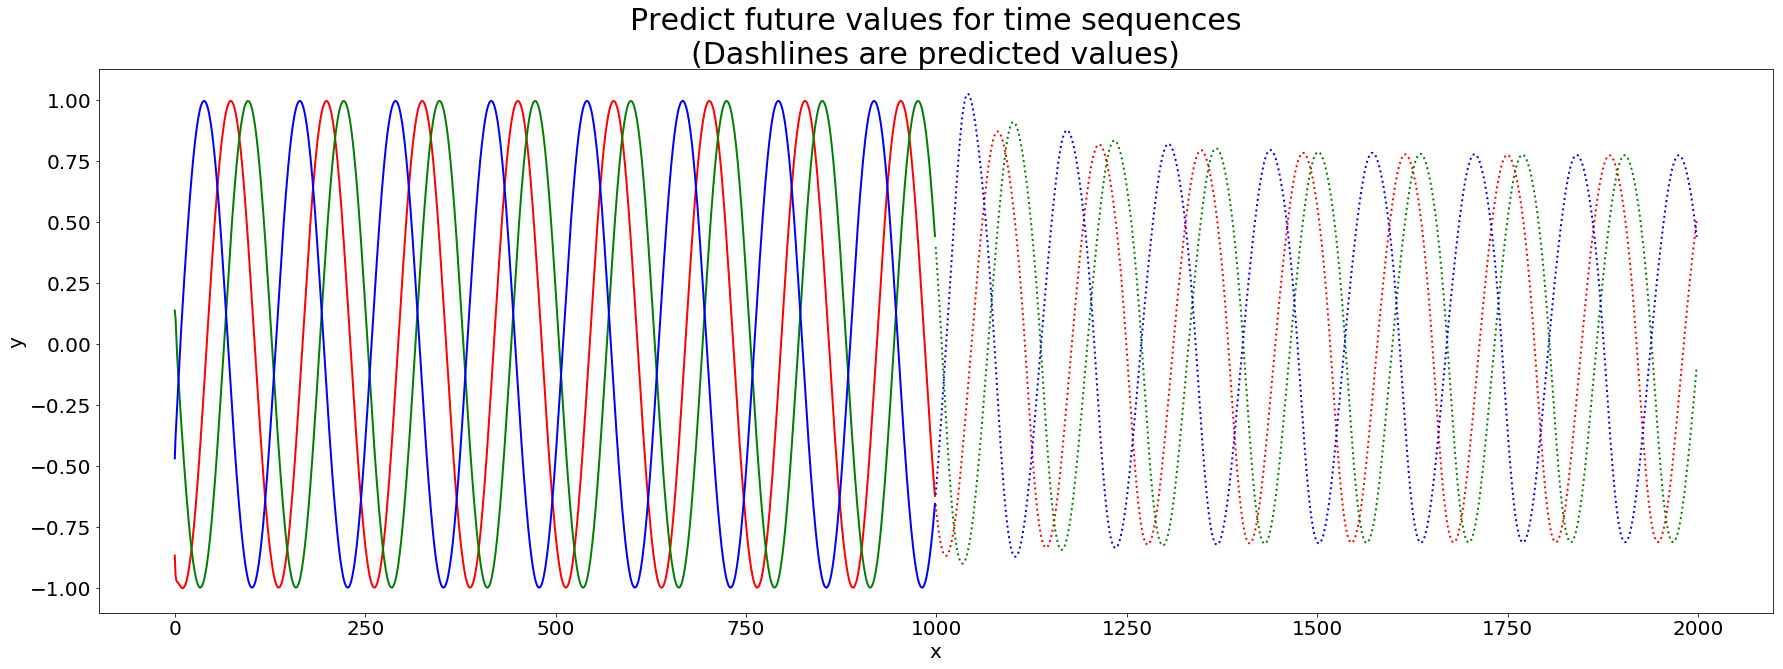

STEP: 5 loss: 1.9253389837103896e-05 test loss: 2.2777589038014412e-05


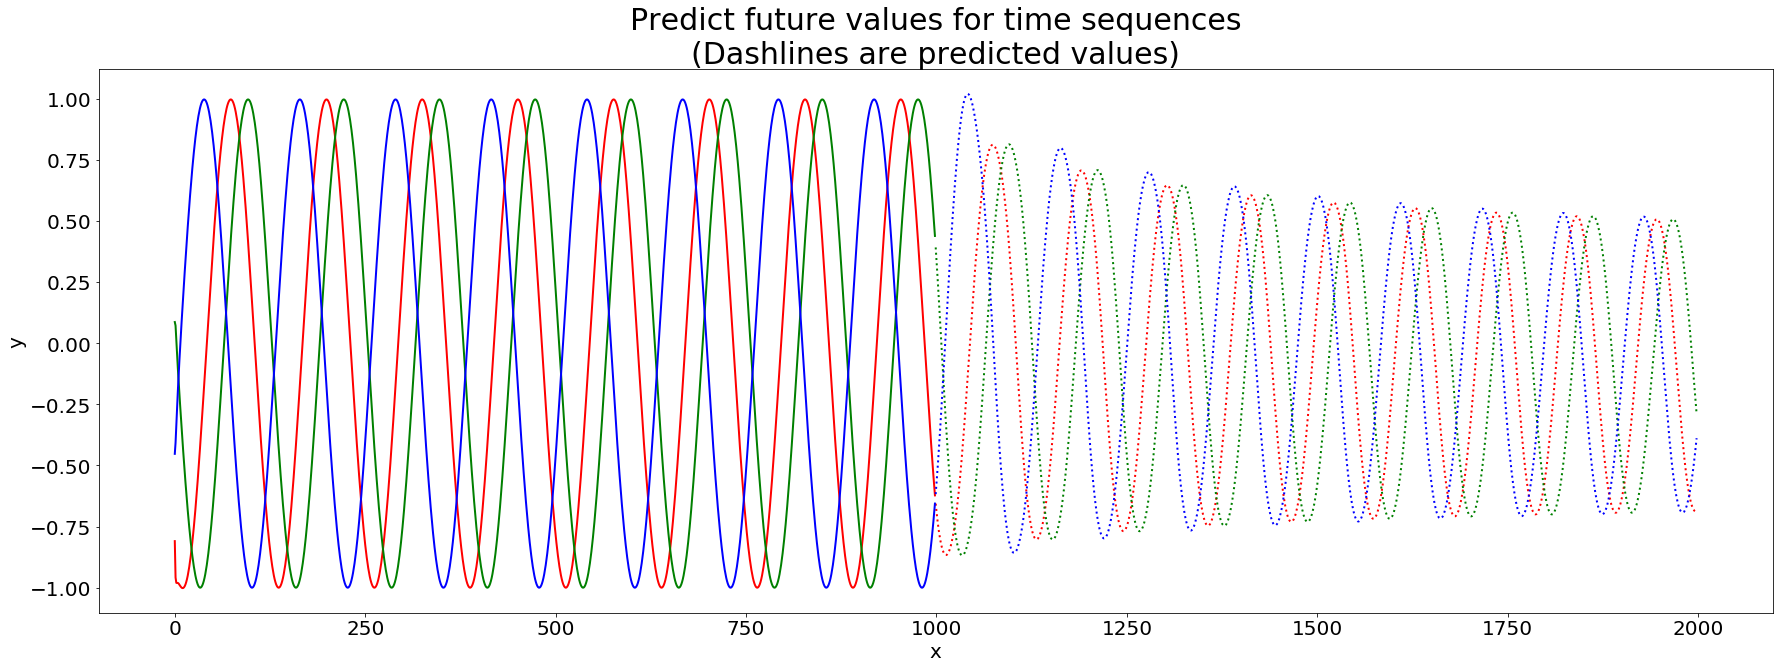

STEP: 6 loss: 1.098178017855389e-055 test loss: 1.297568542213412e-05


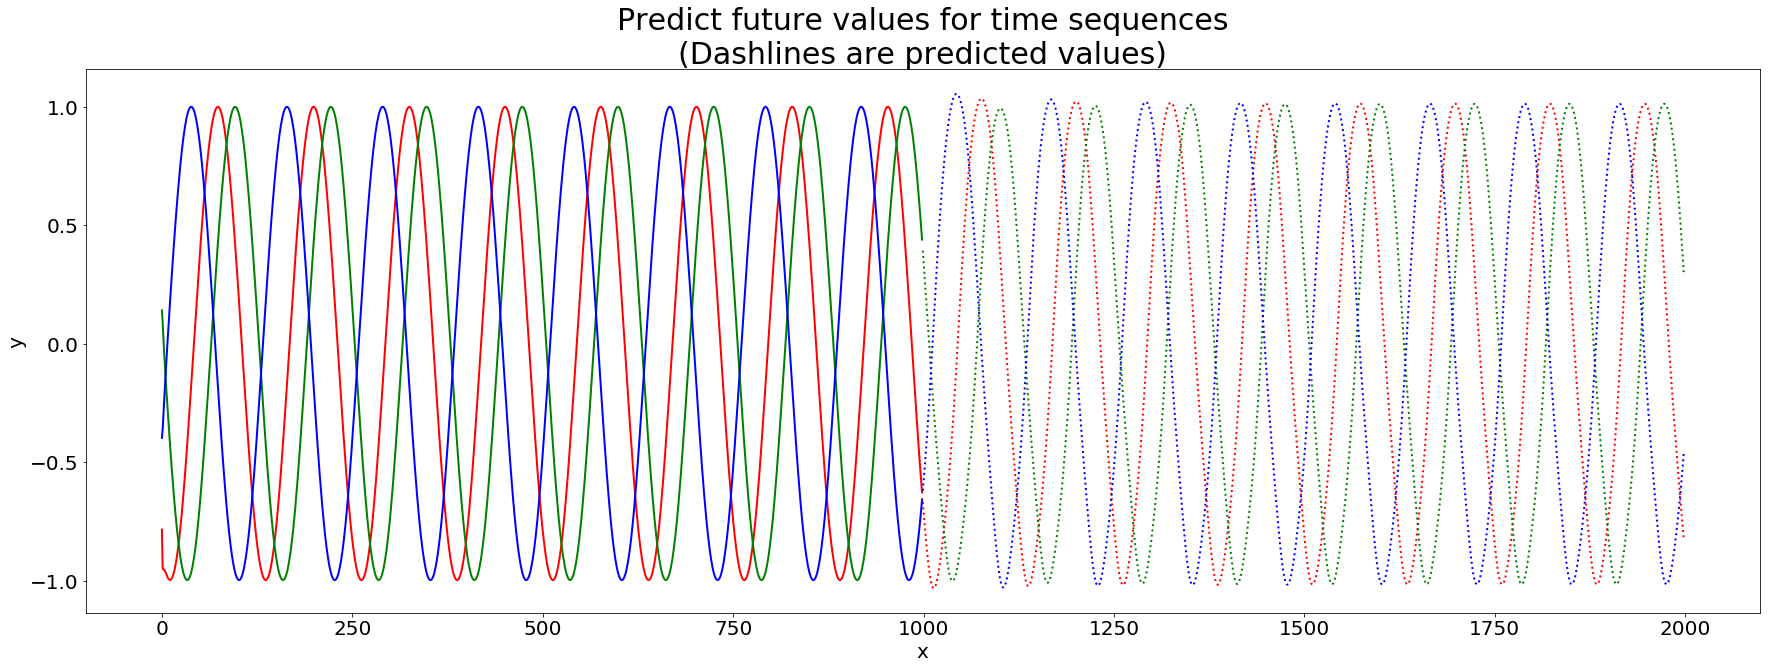

STEP: 7 loss: 7.250616818055278e-065 test loss: 8.652218639326748e-06


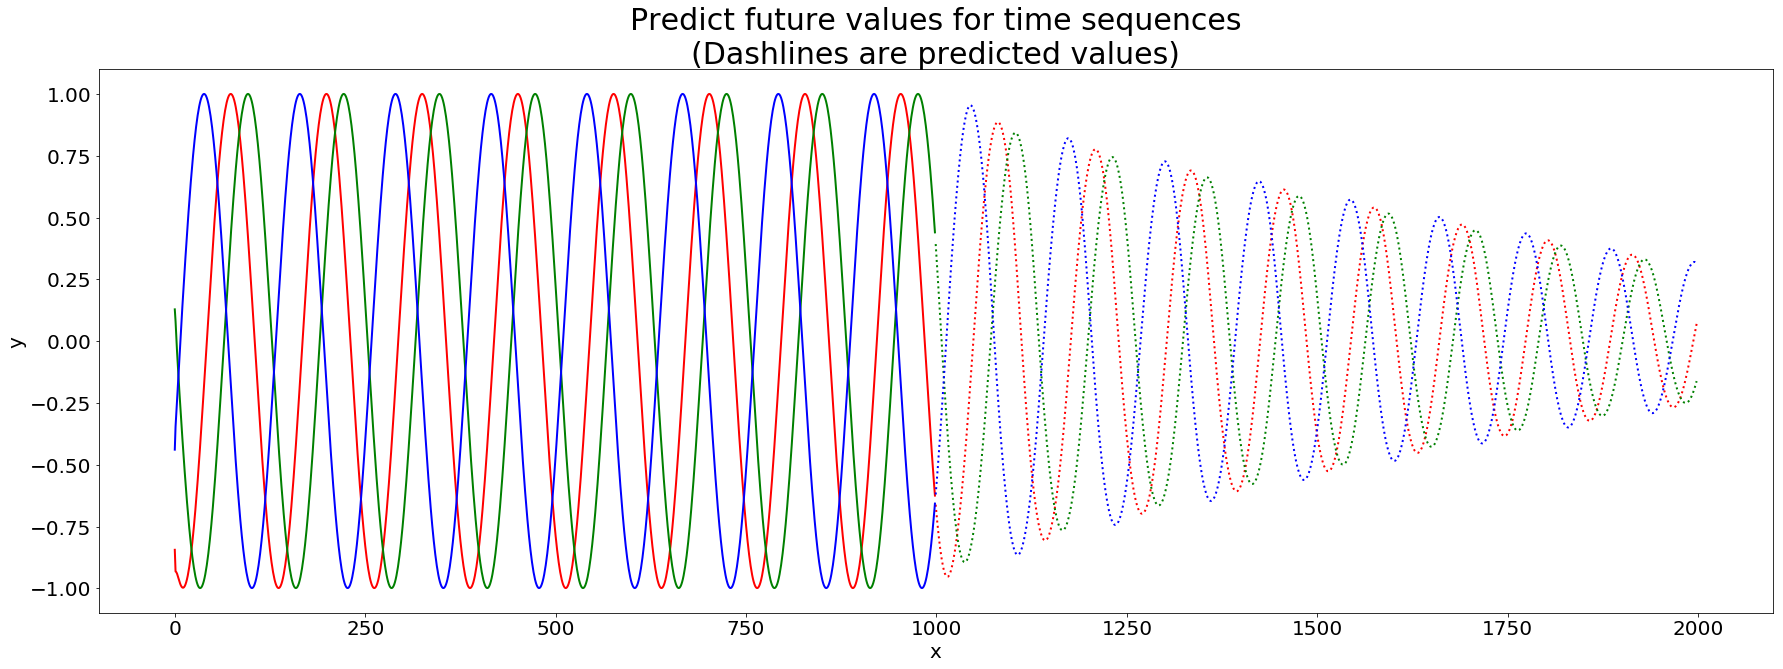

STEP: 8 loss: 6.4141268012463115e-06 test loss: 6.891905741213122e-06


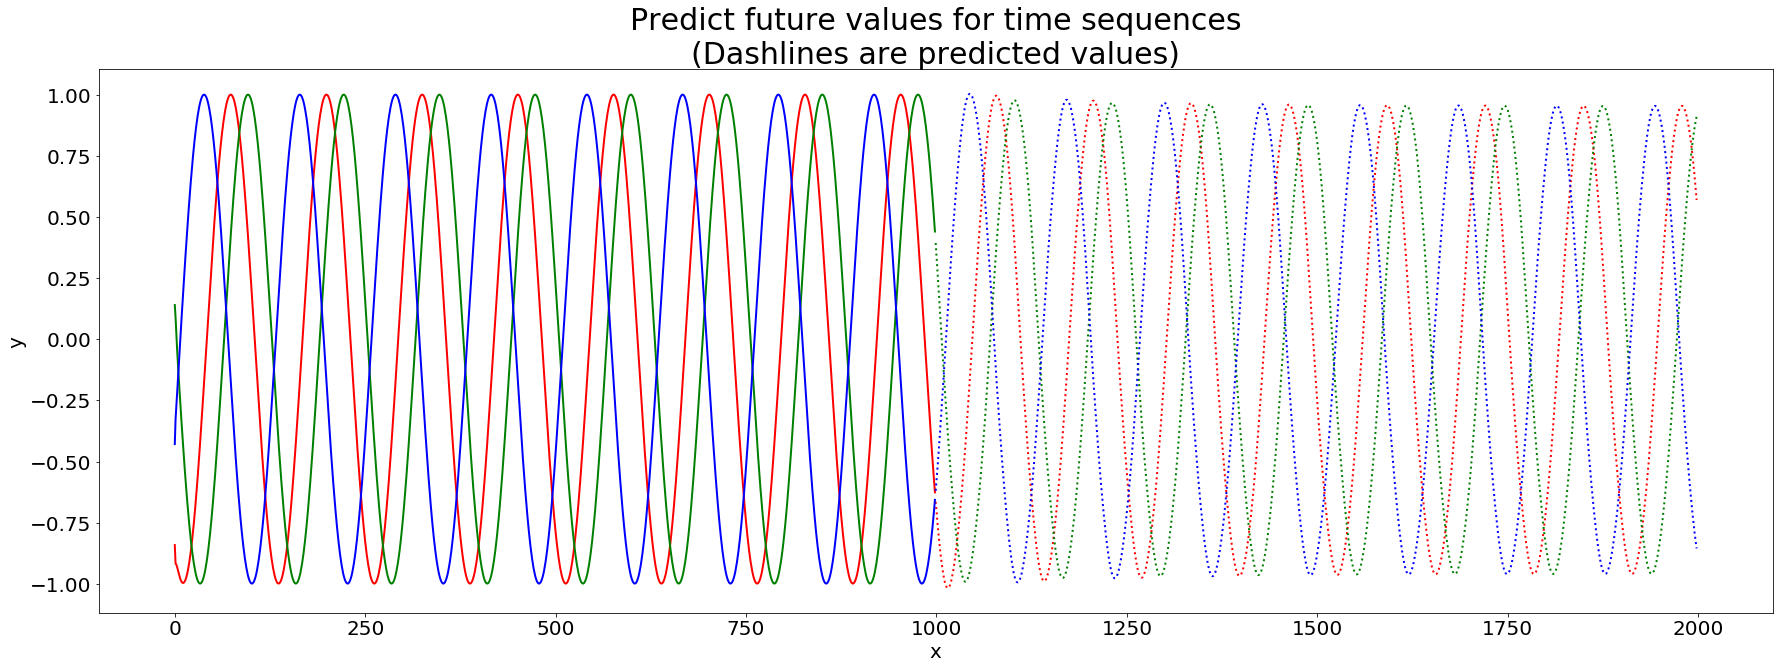

STEP: 9 loss: 6.283110451477114e-066 test loss: 7.038114290480735e-06


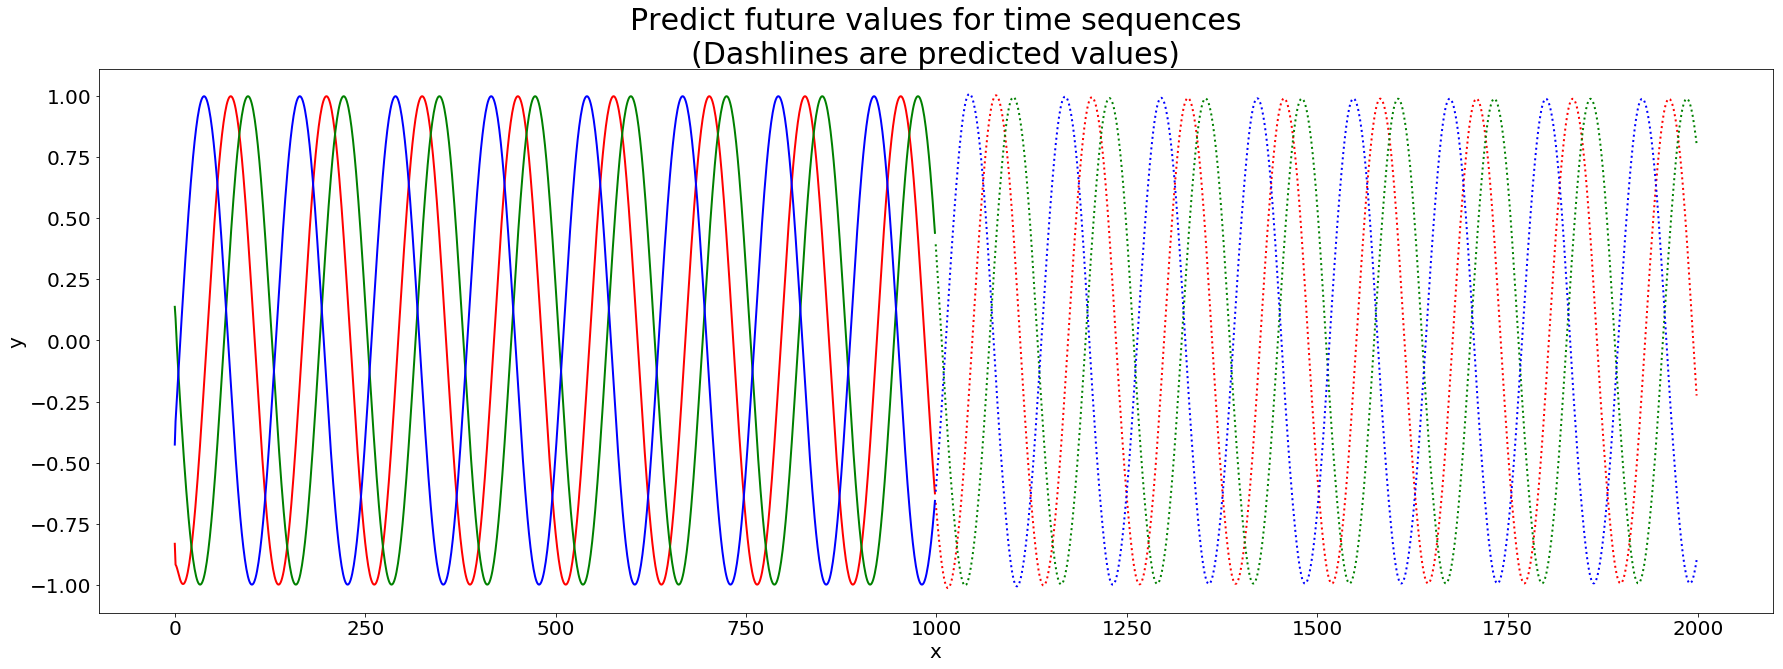

STEP: 10 loss: 6.282415142777609e-06 test loss: 7.04578087606933e-06


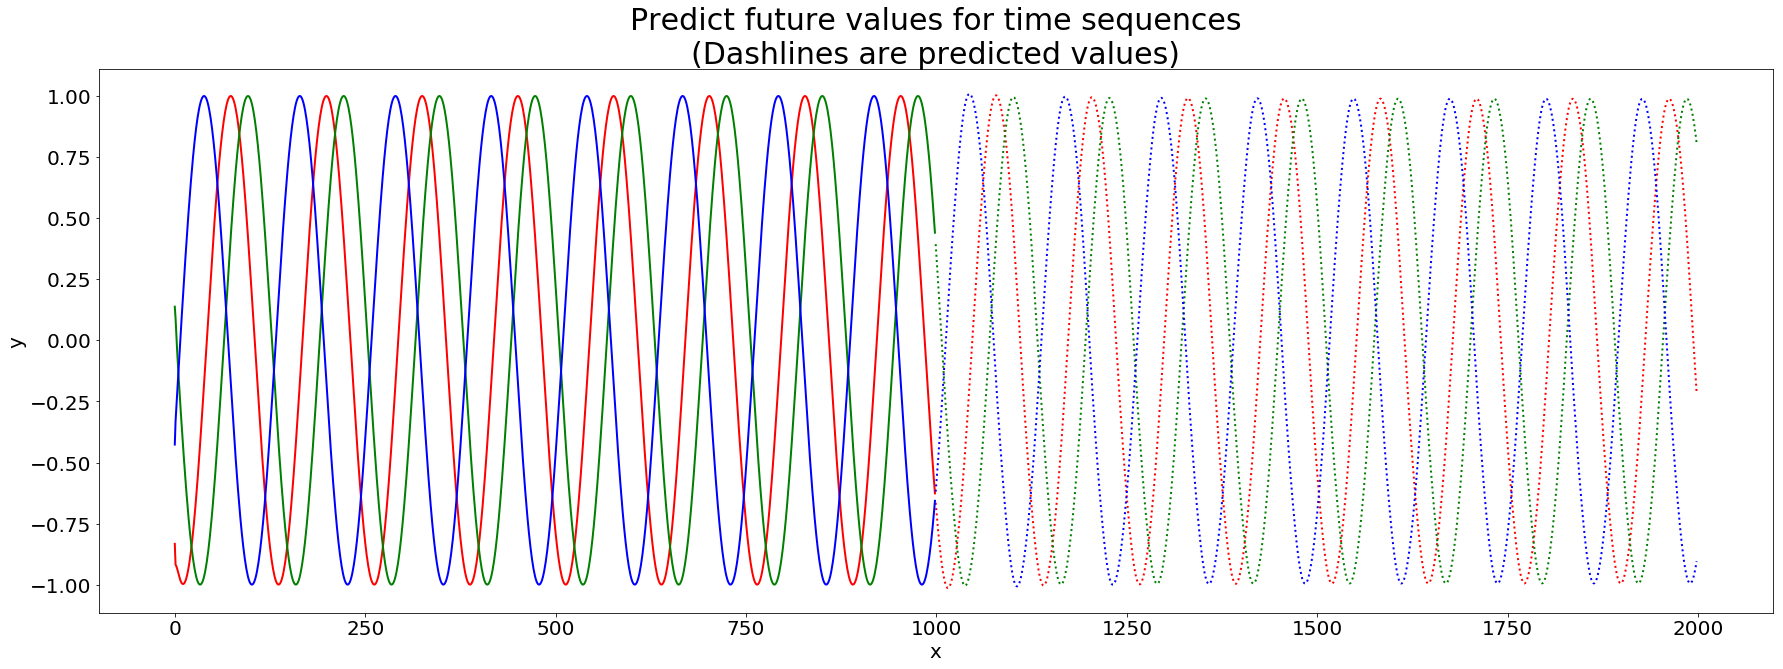

STEP: 11 loss: 5.741732366004726e-066 test loss: 6.734185262757819e-06


STEP: 12 loss: 5.4875367823115084e-06 test loss: 6.715567906212527e-06


STEP: 13 loss: 4.9140949158754665e-06 test loss: 5.454758593259612e-06


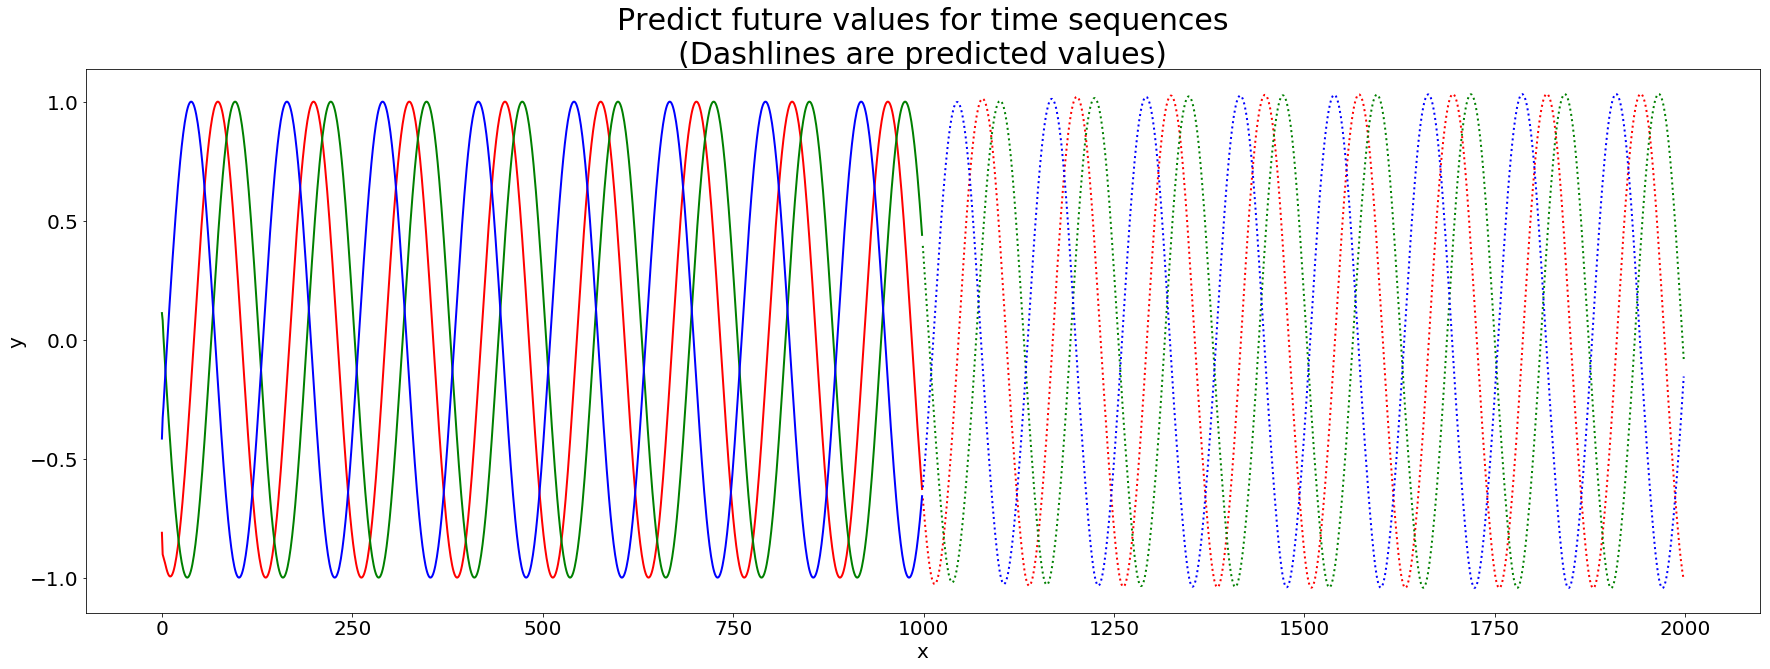

STEP: 14 loss: 4.535554580797907e-066 test loss: 4.959237230650615e-06


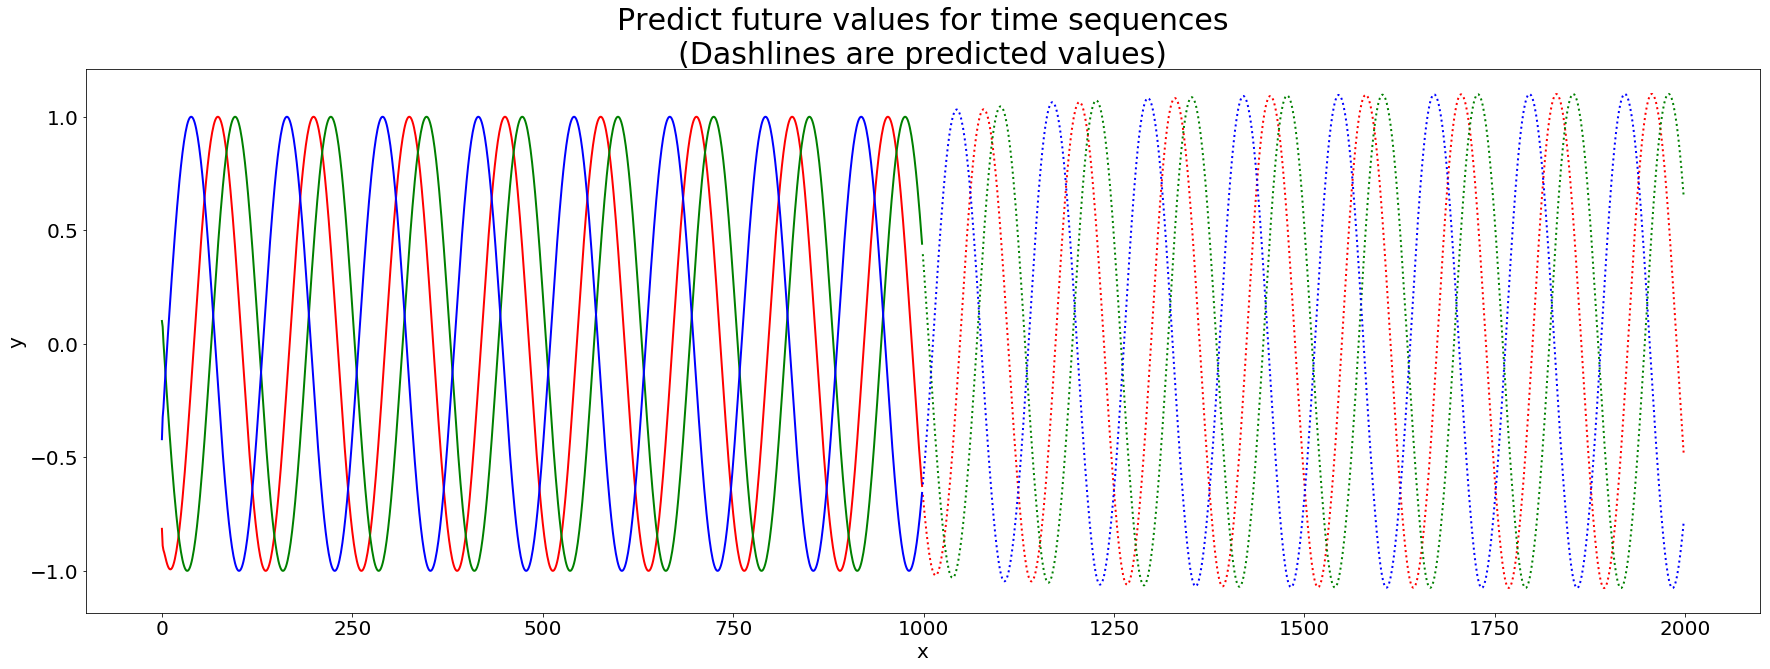

In [5]:
#begin to train
for i in range(15):
    
    
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('\rSTEP:', i,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    optimizer.step(closure)
    
    future = 1000
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()
    #plt.close()



# Sources

RNN : https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

LSTM & GRU : https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21